In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [14]:
GALARY = '/tigress/jiaxuanl/public_html/galary/'
name = 'upg'

### We have already made cuts in `NSA-structure-vanilla-cuts-all.ipynb`. Now we select UPGs, make visual inspection, and plot some useful figures

In [4]:
input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')
from sample_cuts import post_process_cat_new_rbf
cuts_cat = post_process_cat_new_rbf(input_cuts_cat)

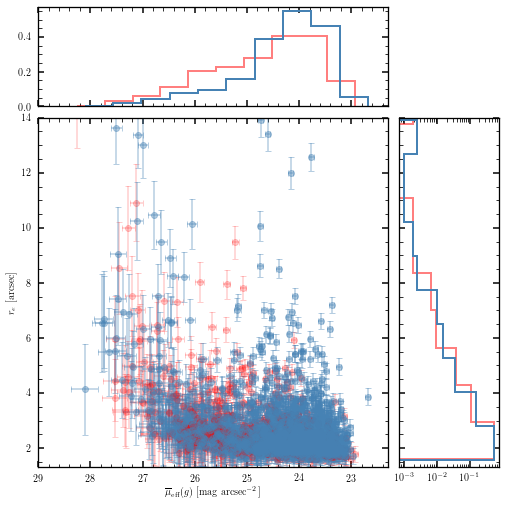

In [5]:
# Distribution of the full sample after junk cuts
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = (cuts_cat['g-i'].data > 0.8)

ax.errorbar(cuts_cat[red]['SB_eff_avg'][:, 0], 
            cuts_cat[red]['rhalf_spergel'], 
            xerr=cuts_cat[red]['SB_eff_avg_err'][:, 0],
            yerr=cuts_cat[red]['rhalf_spergel_err'],
            color='r', fmt='o', alpha=0.2)

ax.errorbar(cuts_cat[~red]['SB_eff_avg'][:, 0], 
            cuts_cat[~red]['rhalf_spergel'], 
            xerr=cuts_cat[~red]['SB_eff_avg_err'][:, 0],
            yerr=cuts_cat[~red]['rhalf_spergel_err'],
            color='steelblue', fmt='o', alpha=0.4)

ax.set_xlim(29, 22.3)
ax.set_ylim(1.3, 14)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm arcsec]$')

ax_histx.hist(cuts_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(cuts_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(cuts_cat[red]['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(cuts_cat[~red]['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

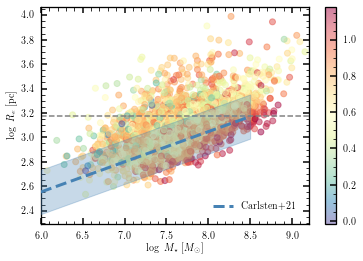

In [6]:
# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(6, 8.5)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3, zorder=10)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21', zorder=10)

plt.scatter(cuts_cat['log_m_star'], 
            np.log10(cuts_cat['rhalf_phys']) + 3, 
            c=cuts_cat['g-i'], cmap='Spectral_r', alpha=0.5, zorder=1)
plt.colorbar()

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ R_{e}\ [\rm pc]$')
plt.legend(loc='lower right')

plt.xlim(6., 9.2)

plt.axhline(np.log10(1500), ls='--', color='gray')

In [15]:
# error not included
thresh = 1.5

flag = (np.log10(cuts_cat['rhalf_phys']) + 3 - mass_size_carlsten(cuts_cat['log_m_star'])) > 0.181 * thresh

print('# of UDGs:', np.sum(flag))

# of UDGs: 392


In [16]:
udg_cat = cuts_cat[flag]

In [17]:
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

# of Candy: 326
# of Gal: 50
# of Junk: 16


In [18]:
udg_cat[['viz-id', 'ra', 'dec']].write(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_w_missed.txt', 
    format='ascii', overwrite=True)

---
### Visual inspection: mark junks

In [39]:
cuts_cat[cuts_cat['viz-id'] == 27138]

viz-id,ra,dec,image_flag,psf_flag,radius,flux,mag,mag_err,g-i,g-i_err,g-r,g-r_err,SB_eff_avg,SB_eff_avg_err,rhalf_spergel,rhalf_spergel_err,rhalf_phys,rhalf_phys_err,abs_mag,abs_mag_err,log_ML_g,log_ML_g_err,log_m_star,log_m_star_err,completeness,tract,patch,synth_id,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,A_g,A_r,A_i,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,host_name,host_z,host_ang_diam_dist,host_stellar_mass,host_halo_mass,host_r_vir,host_r_vir_ang,host_300kpc_ang,host_nvotes,host_spiral,host_elliptical,host_uncertain,host_RA,host_DEC,SB_eff_circ,SB_0,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circularized,spergel_nu,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,S,A_outer,A_shape,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,flag_sersic
,deg,deg,,,arcmin,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),arcsec,arcsec,kpc,kpc,mag(AB),mag(AB),,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,bool[5],bool[5],float64,float64[4],float64[3],float64[3],float64,float64,float64,float64,float64[3],float64[3],float64,float64,float64,float64,float64[3],float64[3],float64,float64,float64,float64,float64,int64,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[4],float64[4],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
27138,129.6172269,-2.0361118,True .. True,True .. True,0.7,3107.171529303415 .. 5323.259768107851,18.247156091105172 .. 17.790409252369475,0.054372364415762264 .. 0.0548830075162832,0.44862466424647524,0.05000125779988637,0.10047696363314193,0.052615402244412704,23.573229850679162 .. 23.116483011943465,0.054372364415762264 .. 0.0548830075162832,4.610828608954996,0.21661566114279848,3.697065037606318,0.17368725999783396,-18.012327819578445 .. -18.469074658314142,0.054372364415762264 .. 0.0548830075162832,-0.43894383849356394,0.06485163136645263,8.777987289337814,0.06840139423166705,0.2219786286554932,9071,"3,5",-1,19.1034,18.7994,18.5842,4.326924,4.5402000000000005,0.0774738236715193,0.054900256737225706,0.03918023560251595,2,0,0,0,0,0,2,2,0,J083901.30-015713.9,0.03919384256005287,165.38786943865566,10.941068976649866,12.826621055603027,486.0260756355005,0.1683753693825338,0.10392983699220804,--,--,--,--,129.75536183317658,-1.9539365674169382,24.617568066526363 .. 24.03303698942125,22.809702515293992 .. 22.22517143818888,0.6263153230058673,0.6263154135804238,1.173887801248815,1.1738878270651922,4.641467574253704,0.754046954098008,14.419156678739274,29.7490327931088,54.06929265297823,0.4977684464407912,-1.720648224020663,-0.3036369708717639,-0.07337934116248895,2.870054135833933,0.00048807893126161234,0.01913855448287391,0.001168832820981316,0.17897864369745842,0.8996924238034252,46.05465415186337,0.6493875992506344,1.1796841571321004,0.0


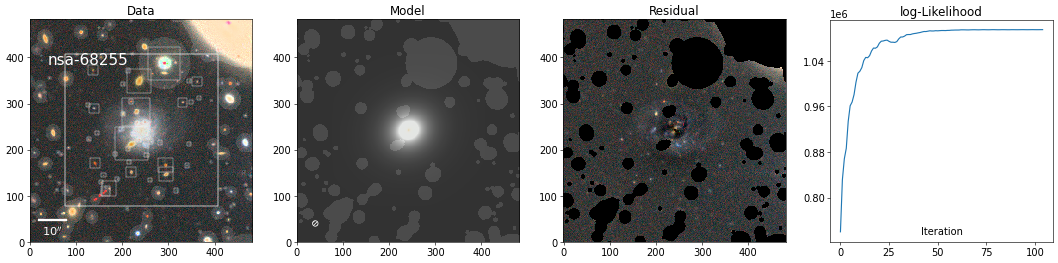

In [30]:
method = 'spergel'
Image.open(f'./Figure/nsa_z002_004/{method}/nsa-68255-zoomin-{method}.png')

In [31]:
votes = Table.read(f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_votes_w_missed.txt',
                   format='ascii')
flag = ~(votes['marked'] == 'true')

In [32]:
udg_cat = udg_cat[flag]

In [33]:
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UPGs:', len(udg_cat))
print('UPG hosts:', len(np.unique(udg_cat['host_name'])))

print('UPG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('')
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

Hosts for LSBGs after cuts: 689

LSBGs after cuts: 2510
UPGs: 371
UPG hosts: 256
UPG fraction: 0.5384615384615384

# of Candy: 318
# of Gal: 45
# of Junk: 8


In [34]:
udg_cat.write(f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits', 
              overwrite=True)
udg_cat[['viz-id', 'ra', 'dec']].write(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.txt', 
    format='ascii', overwrite=True)

### Then 2 sigma definition

In [43]:
# error not included
thresh = 2

flag = (np.log10(cuts_cat['rhalf_phys']) + 3 - mass_size_carlsten(cuts_cat['log_m_star'])) > 0.181 * thresh

print('# of UPGs:', np.sum(flag))

# of UPGs: 186


In [44]:
udg_cat = cuts_cat[flag]

junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

# of Candy: 151
# of Gal: 23
# of Junk: 12


In [45]:
udg_cat.write(f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits', 
              overwrite=True)
udg_cat[['viz-id', 'ra', 'dec']].write(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.txt', 
    format='ascii', overwrite=True)

---

In [16]:
upg_cat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/upg_z001_004_spergel_after_viz_2sigma.fits')

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

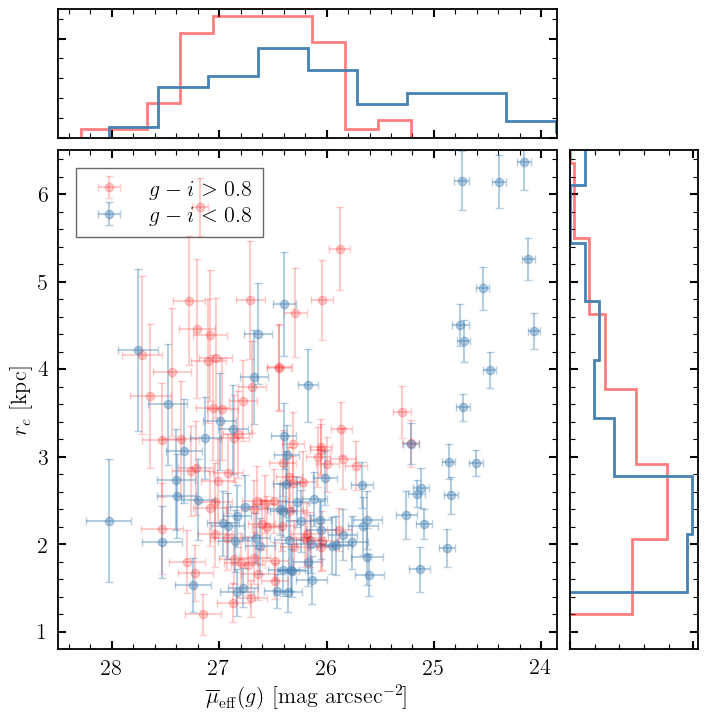

In [17]:
# Distribution of the full sample after junk cuts
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 1.8), height_ratios=(1.8, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.04, hspace=0.04)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = (upg_cat['g-i'].data > 0.8)

ax.errorbar(upg_cat[red]['SB_eff_avg'][:, 0], 
            upg_cat[red]['rhalf_phys'], 
            xerr=upg_cat[red]['SB_eff_avg_err'][:, 0],
            yerr=upg_cat[red]['rhalf_phys_err'],
            color='r', fmt='o', alpha=0.2, label='$g-i > 0.8$')

ax.errorbar(upg_cat[~red]['SB_eff_avg'][:, 0], 
            upg_cat[~red]['rhalf_phys'], 
            xerr=upg_cat[~red]['SB_eff_avg_err'][:, 0],
            yerr=upg_cat[~red]['rhalf_phys_err'],
            color='steelblue', fmt='o', alpha=0.4, label='$g-i < 0.8$')

leg = ax.legend(loc='upper left', frameon=True)
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('dimgray')
leg.get_frame().set_boxstyle('Square', pad=0.)

ax.set_xlim(28.5, 23.85)
ax.set_ylim(0.8, 6.5)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm kpc]$')

ax_histx.hist(upg_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(upg_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(upg_cat[red]['rhalf_phys'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(upg_cat[~red]['rhalf_phys'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histx.set_yticklabels([])
ax_histy.set_xticklabels([])
# ax_histy.set_xscale('log')

In [69]:
kz.set_matplotlib(style='default', usetex=False, dpi=60, fontsize=13)

Text(0.5, 0, '$d_{\\rm ang} / R_{\\rm vir, ang}$')

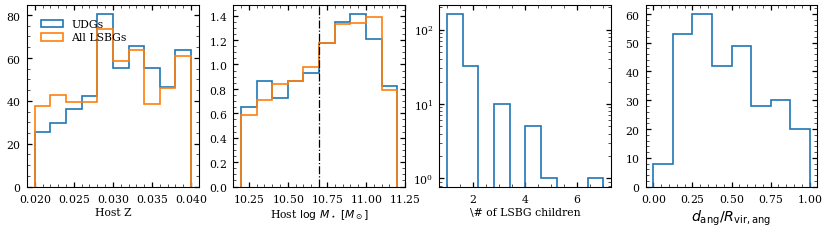

In [71]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(upg_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel('Host Z')
plt.legend(loc='upper left')

plt.sca(axes[1])
plt.hist(upg_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(upg_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('\# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(upg_cat['ra'], upg_cat['dec'], unit='deg')
host_coord = SkyCoord(upg_cat['host_RA'], upg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / upg_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=8, histtype='step', lw=2);
plt.xlabel(r'$d_{\rm ang} / R_{\rm vir, ang}$', fontsize=17)

(array([ 3.,  6., 13., 35., 27., 53., 66., 68., 17.,  2.]),
 array([0.05070742, 0.16439589, 0.27808437, 0.39177285, 0.50546132,
        0.6191498 , 0.73283827, 0.84652675, 0.96021523, 1.0739037 ,
        1.18759218]),
 <BarContainer object of 10 artists>)

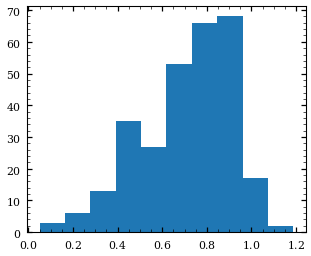

In [75]:
plt.hist(upg_cat['g-i'])

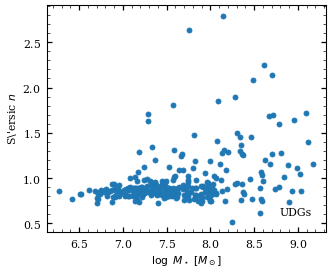

In [76]:
sct = plt.scatter(upg_cat['log_m_star'], 
            upg_cat['sersic_n'], 
            label='UDGs')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'S\'ersic $n$')
plt.legend(loc='lower right')

(array([14., 22., 62., 31., 25., 19., 33., 29., 24., 31.]),
 array([3.91123231e-04, 8.18518575e-02, 1.63312592e-01, 2.44773326e-01,
        3.26234060e-01, 4.07694794e-01, 4.89155529e-01, 5.70616263e-01,
        6.52076997e-01, 7.33537731e-01, 8.14998465e-01]),
 <BarContainer object of 10 artists>)

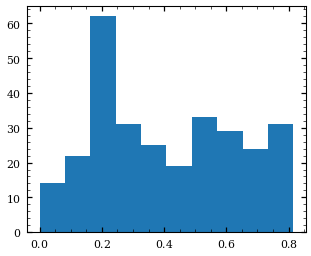

In [77]:
plt.hist(upg_cat['completeness'])

---